<a href="https://colab.research.google.com/github/estebanhernandezr/Redes-de-computadores/blob/main/Proyecto_redes_de_computadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Proyecto_Final_Redes.py***

## **imports**

In [145]:
import numpy as np
import pandas as pd
import copy
import scipy as sp
import networkx as nx
from scipy import sparse
import time
import random as rd
import csv
import matplotlib.pyplot as plt

## **Functions**

In [146]:
def create_random_sparse(nodos = 15):
    # Creates a random sparse matrix given a number of nodes
    # INPUT:
    #   nodos: The number of nodes in the graph
    # OUTPUT:
    #   mA: numpy array of the sparse matriz
    nodos = int(nodos)
    i = 0
    while i <= nodos:
        tmp = np.array([np.random.randint([0, i, 1], [nodos, i+1, 15])])
        if tmp[0][0] != tmp[0][1]:
            if i == 0:
                mA = np.array([np.random.randint([0, i, 1], [nodos, i+1, 15])])
            else:
                mA = np.concatenate((mA, tmp), axis=0)
            i+=1
    i = 0
    while i<int(nodos/2):
        tmp = np.array([np.random.randint([0, 0, 1], [nodos, nodos, 15])])
        if tmp[0][0] != tmp[0][1]:
            mA = np.concatenate((mA, tmp), axis=0)
            i+=1
    return mA

def import_csv(filename):
    # Reads a csv and converts to numpy array
    # INPUT:
    #   filename: name of the csv file
    # OUTPUT:
    #   numpy array of the csv file
    df = pd.read_csv(filename, sep=';')
    return df.to_numpy()

def import_txt(filename):
    # Reads a txt and converts to numpy array
    # INPUT:
    #   filename: name of the txt file
    # OUTPUT:
    #   numpy array of the txt file
    f = open(filename, "r")
    first1 = True
    text = f.readline()
    while text != '':
        a = ''
        b = ''
        c = ''
        start = 'a'
        for i in text:
            if i != ' ' and start == 'a':
                a+=i
            elif i!= ' ' and start == 'b':
                b+=i
            elif i != '\n' and start == 'c':
                c+=i
            else:
                if start == 'a':
                    start = 'b'
                elif start == 'b':
                    start = 'c'
        if first1:
            mT = np.array([[int(a),int(b),int(c)]])
            first1 = False
        else:
            tmp = np.array([[int(a),int(b),int(c)]])
            mT = np.concatenate((mT, tmp), axis=0)
        text = f.readline()
    return mT

## **Classes**

In [147]:
class Node:
    # Class that defines a node of a graph
    def __init__(self, id):
        # Class constructor
        # INPUT:
        #   id: int that identifies node
        self.id = id
        self.neighs = []
        self.distance = np.inf
        self.predecessor = None

    def add_neigh(self, node, weight):
        # Adds nodes to the neighs list of the node
        # INPUT:
        #   node: object Node
        #   weight: weight of the edge
        self.neighs.append((node, float(weight)))

class Graph(Node):
    # Class that creates a graph
    def __init__(self, sparse_mat):
        # Class constructor
        # INPUT:
        #   sparse_mat: np.array with [node A, node B, weight] as rows

        self.nodes = []
        self.sparse = sparse_mat

        for row in sparse_mat:
            node_A = row[0]
            node_B = row[1]
            weight = row[2]

            A_in_graph = self.node_in_graph(node_A)
            B_in_graph = self.node_in_graph(node_B)

            if A_in_graph == False:
                self.nodes.append(Node(node_A))
            
                if B_in_graph == False:
                    self.nodes.append(Node(node_B))
                    self.nodes[-2].add_neigh(self.nodes[-1], weight)
                    self.nodes[-1].add_neigh(self.nodes[-2], weight)

                else: # B_in_graph -> index where node B is in self.nodes
                    self.nodes[-1].add_neigh(self.nodes[B_in_graph-1], weight)
                    self.nodes[B_in_graph-1].add_neigh(self.nodes[-1], weight)
                
            else:
                if B_in_graph == False:
                    self.nodes.append(Node(node_B))
                    self.nodes[-1].add_neigh(self.nodes[A_in_graph-1], weight)
                    self.nodes[A_in_graph-1].add_neigh(self.nodes[-1], weight)

                else:
                    self.nodes[A_in_graph-1].add_neigh(self.nodes[B_in_graph-1], weight)
                    self.nodes[B_in_graph-1].add_neigh(self.nodes[A_in_graph-1], weight)

    def node_in_graph(self, node_id):
        # determines whether or not a node is in a graph. Looks for it in self.nodes
        # INPUT:
        #   node_id: int that specifies the node to look for
        # OUTPUT:
        #   returns index of the node in the list if exists, if not return False
        for idx, node in enumerate(self.nodes):
            if node.id == node_id: 
                return idx+1
        return False

    def _min_dist(self, nodes):
        # determines the minimum distance of a list of nodes
        # INPUT:
        #   nodes: list of nodes to look on
        # OUTPUT:
        #   min_node: the node with the minimum distance
        min_node = nodes[0]
        min_dist = min_node.distance
        for i in range(1, len(nodes)):
            if nodes[i].distance < min_dist:
                min_dist = nodes[i].distance
                min_node = nodes[i]
        return min_node

    def sparse2adj(self, sparse):
        # transforms a sparse matrix into a adjacency matrix
        # INPUT:
        #   sparse: numpy array - sparse matrix of graph
        # OUTPUT:
        #   adj: numpy array - adjacency matrix of graph
        adj = np.zeros((len(self.nodes),len(self.nodes)))
        for row in sparse:
            node_A = int(row[0])
            node_B = int(row[1])
            weight = float(row[2])
            adj[node_A][node_B] = weight
            adj[node_B][node_A] = weight
        return adj

    def draw_graph(self):
        # draws each node and its corresponding edges
        G = nx.convert_matrix.from_numpy_array(self.sparse2adj(self.sparse))
        pos = nx.spring_layout(G)
        labels = {}
        for i in self.sparse:
            labels.setdefault((i[0],i[1]),i[2])
        plt.title("Graph visualization")
        nx.draw(G, pos, with_labels = True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels = labels)
        plt.show()
        
    def routing_table(self):
        # determines and prints the routing table the graph
        # OUTPUT:
        #   table: DataFrame of the routing table of graph
        id = []
        dist = []
        pred = []
        for node in self.nodes:
            id.append(node.id)
            dist.append(node.distance)
            pred.append(node.predecessor)
        table = np.column_stack((id,dist,pred))
        table = pd.DataFrame(table)
        table.columns = ["id", "distance", "predecessor"]
        print("\n ----------------- Routing Table ---------------------- \n")
        print(table.to_string(index=False))
        return table

    def draw_tree(self, route_table):
        # draws the tree corresponding to the routing table
        # INPUT:
        #   routing_table: DataFrame with the routing table
        route_m = route_table.to_numpy()
        route_m[:, [2, 1]] = route_m[:, [1, 2]] 
        route_m = np.delete(route_m, (0), axis=0)
        G = nx.convert_matrix.from_numpy_array(self.sparse2adj(route_m))
        plt.title("Final Tree")
        nx.draw(G, with_labels = True)
        plt.show()
    
    def dijkstra(self, node):
        # Performs Dijkstra's algorithm and plots the original graph and the resulting tree

        actual = node
        actual.distance = 0
        actual.predecessor = -1
        unvisited = copy.copy(self.nodes)

        while len(unvisited) > 0:
            for neigh in actual.neighs:
                if neigh[0] in unvisited: #se puede crear un atributo
                    temp_dist = actual.distance + neigh[1]
                    if temp_dist < neigh[0].distance:
                        neigh[0].distance = temp_dist
                        neigh[0].predecessor = actual.id
            unvisited.remove(actual)
            if len(unvisited) != 0:
                actual = self._min_dist(unvisited)

        #self.draw_tree(self.routing_table())

# ***main_Proyecto_Final_Redes.py***


 Welcome to Link-State routing Tool based on Dijkstra!
Select 0 if you want me to create a random graph for you. Press 1 if you want to upload it 
 Type your selection and press enter: 0
Choose the number of nodes in the graph. They must be between 15 and 50: 15
Nodos: 
[<__main__.Node object at 0x7f6f4a11f050>, <__main__.Node object at 0x7f6f49c51e90>, <__main__.Node object at 0x7f6f4a109450>, <__main__.Node object at 0x7f6f49c37750>, <__main__.Node object at 0x7f6f49c37dd0>, <__main__.Node object at 0x7f6f49c37d90>, <__main__.Node object at 0x7f6f49c37e10>, <__main__.Node object at 0x7f6f49c37b50>, <__main__.Node object at 0x7f6f49c37090>, <__main__.Node object at 0x7f6f49c37d50>, <__main__.Node object at 0x7f6f49d37850>, <__main__.Node object at 0x7f6f49d37a50>, <__main__.Node object at 0x7f6f49d37f90>, <__main__.Node object at 0x7f6f49d372d0>, <__main__.Node object at 0x7f6f49d37d50>, <__main__.Node object at 0x7f6f49d37ed0>]
Aristas:
[[10  0  6]
 [ 9  1  6]
 [10  2  1]
 [ 4  3  8

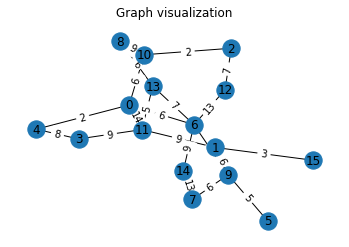

In [148]:
# Redes de Computadores 2022
# Universidad del Rosario - School of Engineering, Science and Technology
# Pr. David Celeita

# This is 0 main function. The interaction between user and tool si performed here.

print("\n Welcome to Link-State routing Tool based on Dijkstra!")

selection = input("Select 0 if you want me to create a random graph for you. Press 1 if you want to upload it \n Type your selection and press enter: ")

if selection == '0':
    is_valid = False
    while is_valid != True:
        num_nodes = int(input("Choose the number of nodes in the graph. They must be between 15 and 50: "))
        if 15 <= num_nodes and num_nodes <= 50:
            is_valid = True

    rand_sparse = create_random_sparse(num_nodes) 
    graph = Graph(rand_sparse)
    print('Nodos: ')
    print(graph.nodes)
    print('Aristas:')
    print(graph.sparse)
    print('(nodo1, nodo2, peso arista)')
    graph.draw_graph()
    #graph.dijkstra()

else:
    is_valid = False
    while is_valid != True:
        doc_type = str(input("If you want to upload a CSV file type CSV or if you want a TXT file type TXT. \n Type your selection and press enter: "))
        if doc_type == "CSV" or doc_type == "TXT":
            is_valid = True
    
    filename = input("\n Now, type the name of the file. Remember that it must be in the same folder of this .exe or specify the whole path. \n Type you filename with the extension: ")
    
    if doc_type == "CSV":
        sparse_m = import_csv(filename)
        graph = Graph(sparse_m)
        graph.draw_graph()
        graph.dijkstra()

    else:
        sparse_m = import_txt(filename)
        graph = Graph(sparse_m)
        graph.draw_graph()
        graph.dijkstra()


# **Modelling**

In [153]:
def build_capacity_matrix(nodes, links):
    capacities = np.zeros((len(nodes), len(nodes)), dtype=int)
    for node_i in nodes:
        for node_j in nodes:
            for link in links:
                if (link[0] == node_i.id and link[1] == node_j.id):
                    i = node_i.id
                    j = node_j.id
                    capacities[i, j] = link[2] # CAMBIAR ESTE VALOR POR DEFECTO POR ALGÚN VALOR DE CAPACIDAD ARTIFICIAL 
    return capacities

def traverse_spaning_tree(span_tree, node_id, dest_id, flag):
    if (flag):
        return [node_id]
    if (node_id == dest_id):
        print('base case: destination')
        return [dest_id]
    else:  
        filas_sucesor = span_tree[span_tree['predecessor']==node_id]
        if (filas_sucesor.empty):
            path = traverse_spaning_tree(span_tree, node_id, dest_id, True)
            path += [node_id]
        else:
            path = []
            for index, row in filas_sucesor.iterrows():
                sucesor = row['id']
                aux_path = traverse_spaning_tree(span_tree, sucesor, dest_id, False)
                if dest_id in aux_path:
                    path += aux_path
                    path += [node_id]
        return path

def build_demands_matrix(grafo, demand): # demand := (bandwitdh demand, source node id, destination node id)
    path = build_OSPF_path(grafo, demand)
    path.reverse()
    for i in range(0, len(path)-1):
        print(path[i])
        print(path[i+1])

def build_OSPF_path(grafo, demand): # demand := (bandwitdh demand, source node id, destination node id)
    nuevo_grafo = copy.deepcopy(grafo)
    V = nuevo_grafo.nodes
    E = nuevo_grafo.sparse
    print(nuevo_grafo)
    bandwidth = demand[0]
    source = demand[1]
    destination = demand[2]
    for node in V:
        if (node.id == source):
            source = node
        if (node.id == destination):
            destination = node
    print("FROM ", source.id, " TO ", destination.id)
    nuevo_grafo.dijkstra(node = nuevo_grafo.nodes[nuevo_grafo.nodes.index(source)])
    path = traverse_spaning_tree(nuevo_grafo.routing_table(), source.id, destination.id, False)
    print(path)
    return path

In [154]:
V = graph.nodes
E = graph.sparse
capacities = build_capacity_matrix(V, E)
K = [(8, 0, 6), (13, 2, 7), (100, 7, 3), (5, 9, 8)]
build_demands_matrix(graph, K[1])
build_OSPF_path(graph, K[1])

FROM  2  TO  7

 ----------------- Routing Table ---------------------- 

  id  distance  predecessor
10.0       1.0          2.0
 0.0       7.0         10.0
 9.0      21.0          6.0
 1.0      27.0          9.0
 2.0       0.0         -1.0
 4.0       9.0          0.0
 3.0      17.0          4.0
 5.0      26.0          9.0
 6.0      13.0          0.0
14.0      22.0          6.0
 7.0      27.0          9.0
 8.0      10.0         10.0
11.0      21.0          0.0
12.0       7.0          2.0
13.0      16.0          8.0
15.0      30.0          1.0
base case: destination
[7, 9.0, 6.0, 0.0, 10.0, 2]
2
10.0
10.0
0.0
0.0
6.0
6.0
9.0
9.0
7
FROM  2  TO  7

 ----------------- Routing Table ---------------------- 

  id  distance  predecessor
10.0       1.0          2.0
 0.0       7.0         10.0
 9.0      21.0          6.0
 1.0      27.0          9.0
 2.0       0.0         -1.0
 4.0       9.0          0.0
 3.0      17.0          4.0
 5.0      26.0          9.0
 6.0      13.0          0.0
14.0   

[7, 9.0, 6.0, 0.0, 10.0, 2]

In [151]:
print(capacities)

[[ 0  0  0  0  2  0  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  7  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  4  9  0]
 [ 0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  5  8  0  0  0  0  0  0  0  0  0]
 [ 6  0  1  0  0  0  0  0  9  0  0  0  0  0  0  0]
 [14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  6  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
